## imports

In [1]:
# ======= imports
import copy
import cv2
import numpy as np
from src.helpers.frame_helpers import *
import open3d as o3d

model_path = "3d_models/ImageToStl.com_rubber_duck/ImageToStl.com_rubber_duck.obj"  # Update with your model path
mesh = o3d.io.read_triangle_mesh(model_path, True)
# model = FrameHelpers.load_glb_with_materials(model_path)
# Convert to legacy format for visualization
# mesh_legacy = o3d.geometry.TriangleMesh.from_legacy(model.to_legacy())

# Check if the model has textures
print("Has vertex colors?", mesh.has_vertex_colors())
print("Has textures?", mesh.has_textures())

mesh.compute_vertex_normals()  # Compute normals for better rendering
# o3d.visualization.draw_geometries([model])

# ======= constants
feature_extractor = cv2.SIFT_create(nfeatures=500, edgeThreshold = 20)
bf = cv2.BFMatcher()

replace_image_path = 'images/pattern_chessboard.png'
replace_img = cv2.imread(replace_image_path)
replace_img[replace_img == 0] = 1
if replace_img is None:
    raise FileNotFoundError(f"Replace image not found at {replace_image_path}")
# taked data previusly saved using: np.savez('calibration_data.npz', mtx=mtx, dist=dist)
calibration_data_path = 'calibration_data.npz'
# load camera calibration data
calibration_data = np.load(calibration_data_path) # keys: mtx, dist, rvecs, tvecs
K = calibration_data['mtx']
dist_coeffs = calibration_data['dist']
# ====== cube object points
chessboard_size = (9, 6)
square_size = 2.5  # Cube height in cm
# Desired starting square (i, j)
i, j = 2, 3
corner_index = j * chessboard_size[0] + i

# Prepare object points
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

# Shift the object points to start from the desired square
objp[:, 0] -= i * square_size
objp[:, 1] -= j * square_size

# Cube 3D points
cube_points = 3 * square_size * np.float32([
    [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
    [0, 0, -1], [1, 0, -1], [1, 1, -1], [0, 1, -1]
])

cube_points_2 = 3 * square_size * np.float32([[0,0,0], [0,1,0], [1,1,0], [1,0,0],
                   [0,0,-1],[0,1,-1],[1,1,-1],[1,0,-1] ])

rectangle_points = square_size * np.float32([
    [0, 0, 0], [2, 0, 0], [2, 3, 0], [0, 3, 0],  # Bottom face
    [0, 0, -1], [2, 0, -1], [2, 3, -1], [0, 3, -1]  # Top face
])

axis = 3 * square_size * np.float32([[0, 0, 0], [1,0,0], [0,1,0], [0,0,-1]]).reshape(-1,3)

def draw_axises(img, imgpts):
    imgpts = imgpts.astype("int32")
    center = tuple(imgpts[0].ravel())
    img = cv2.line(img, center, tuple(imgpts[1].ravel()), (255,0,0), 5)
    img = cv2.line(img, center, tuple(imgpts[2].ravel()), (0,255,0), 5)
    img = cv2.line(img, center, tuple(imgpts[3].ravel()), (0,0,255), 5)
    return img

def draw_cube(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -1)

    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img

# === template image keypoint and descriptors
template_image_path = 'images/features_page-0001.jpg'
template_img = cv2.imread(template_image_path)
template_img = cv2.resize(
    template_img, (template_img.shape[1] // 2, template_img.shape[0] // 2))
replace_img = cv2.resize(
    replace_img, (template_img.shape[1], template_img.shape[0]))
if template_img is None:
    raise FileNotFoundError(
        f"Template image not found at {template_image_path}")

gray_template = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_keypoints, template_descriptors = feature_extractor.detectAndCompute(
    gray_template, None)

rgp_template = cv2.drawKeypoints(
    gray_template, template_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imshow('Template image with keypoints', rgp_template)


# ===== video input, output and metadata
step_size = 1
frame_helpers = FrameHelpers()
video_path = 'videos/videos10/video10.mp4'
frames, new_size = frame_helpers.get_video_frames_and_params(video_path)
print("frames len:", len(frames))
input_video = cv2.VideoCapture(video_path) 

output_video_path = 'videos/output_perspective_warping.avi'
fps = input_video.get(cv2.CAP_PROP_FPS) // step_size
# Create a VideoWriter for saving output
output_writer = cv2.VideoWriter(
    output_video_path,
    cv2.VideoWriter_fourcc(*'XVID'),
    fps,
    new_size
)

# ========== run on all frames
width, height = frames[0].shape[1], frames[0].shape[0]    # Image dimensions
print(width, height)
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]

# Create Open3D intrinsic object
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

frame_index = 0
alpha = 0.4  # Smoothing factor for EMA
prev_H = None
frame_index = 0
print("----------------------frame index:", frame_index)

frame = frames[frame_index].copy()
# ====== find keypoints matches of frame and template
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# find the keypoints and descriptors with chosen feature_extractor
kp_frame, desc_frame = feature_extractor.detectAndCompute(
    gray_frame, None)

test_frame = cv2.drawKeypoints(
    rgb_frame, kp_frame, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# cv2.imshow('Frame with keypoints', test_frame)

# ======== find homography
# Match descriptors using KNN Matcher
matches = bf.knnMatch(template_descriptors, desc_frame, k=2)

# Apply ratio test
good_match_arr = []
for m, n in matches:
    if m.distance < 1 * n.distance:
        good_match_arr.append(m)
# take top 10 with lowest distance
good_match_arr = sorted(
    good_match_arr, key=lambda x: x.distance)[:75]
if len(good_match_arr) < 4:
    print("Not enough matches found- len: ", len(good_match_arr))
    frame_index += step_size
    raise

# Extract matched keypoints
src_pts = np.array(
    [template_keypoints[m.queryIdx].pt for m in good_match_arr])
dst_pts = np.array([kp_frame[m.trainIdx].pt for m in good_match_arr])
    
frame = frames[frame_index].copy()
# Draw matches for visualization
match_img = cv2.drawMatches(template_img, template_keypoints, frame, kp_frame,
                            good_match_arr, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# cv2.imshow('Matches', match_img)

# Compute Homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
# ++++++++ do warping of another image on template image
if H is not None:
    # Smooth the transition using exponential moving average
    if prev_H is not None:
        H = alpha * H + (1 - alpha) * prev_H
    prev_H = H
    
    # Warp the cat image using the homography
    warped_replace = cv2.warpPerspective(
        replace_img, H, (frame.shape[1], frame.shape[0]))

    # Create a mask for overlay blending
    mask_warped = np.zeros_like(frame, dtype=np.uint8)
    frame[warped_replace > 0] = 0
    # Blend the warped image onto the frame
    frame = frame + warped_replace
    # cv2.putText(frame, f"Frame: {frame_index}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.imshow("wraped_replace", warped_replace)
else:
    print("Homography not found")
    frame_index + step_size
    raise # take prev frame- no homography found

# imgpts = cv2.projectPoints(cube_points, rvecs[frame_index], tvecs[frame_index], mtx, dist)[0]
# drawn_image = draw_obj(frame, imgpts)
# Show output frame
# cv2.imshow('Chessboard', frame)


# ++++++++ take subset of keypoints that obey homography (both frame and reference)
# this is at most 3 lines- 2 of which are really the same
# HINT: the function from above should give you this almost completely
gray_wraped_frame = cv2.cvtColor(warped_replace, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray_wraped_frame, chessboard_size, None)
if not ret:
    print("Chessboard not found in warped image")
    frame_index += step_size
    raise
sub_corners = cv2.cornerSubPix(gray_wraped_frame, corners, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
# Get the pixel coordinates of the desired corner
corner_pixel = np.floor(corners[corner_index][0]).astype(int)
# Draw the corner on the frame
cv2.circle(frame, tuple(corner_pixel), 10, (0, 255, 0), -1)
# ++++++++ solve PnP to get cam pose (r_vec and t_vec)
# `cv2.solvePnP` is a function that receives:
# - xyz of the template in centimeter in camera world (x,3)
# - uv coordinates (x,2) of frame that corresponds to the xyz triplets
# - camera K
# - camera dist_coeffs
# and outputs the camera pose (r_vec and t_vec) such that the uv is aligned with the xyz.
#
# NOTICE: the first input to `cv2.solvePnP` is (x,3) vector of xyz in centimeter- but we have the template keypoints in uv
# because they are all on the same plane we can assume z=0 and simply rescale each keypoint to the ACTUAL WORLD SIZE IN CM.
# For this we just need the template width and height in cm.
#
# this part is 2 rows
print(sub_corners.shape)
ret, rvec, tvec = cv2.solvePnP(objp, sub_corners, K, dist_coeffs)

# ++++++ draw object with r_vec and t_vec on top of rgb frame
# We saw how to draw cubes in camera calibration. (copy paste)
# after this works you can replace this with the draw function from the renderer class renderer.draw() (1 line)
if ret:
    imgpts = cv2.projectPoints(axis, rvec, tvec, K, dist_coeffs)[0]
    # ret, rvec, tvec = cv2.solvePnP(axis, imgpts, K, dist_coeffs)
    draw_axises(frame, imgpts)
    # cv2.imshow(frame)
    imgpts = cv2.projectPoints(cube_points_2, rvec, tvec, K, dist_coeffs)[0]
    
    # draw_cube(frame, imgpts)
    # draw_cube(frame, imgpts)
    # Get the bounding box of the projected points
    x_min, y_min = np.min(imgpts[:, 0, :], axis=0).astype(int)
    x_max, y_max = np.max(imgpts[:, 0, :], axis=0).astype(int)

    model = copy.deepcopy(mesh)

    # rendered_model = frame_helpers.render_model(
    #     model, rvec, tvec, intrinsic, width, height)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Has vertex colors? False
Has textures? True
pickle folder path: pickle_files/video10
chunk file: chunk_0.pkl
frames len: 100
960 540
----------------------frame index: 0
(54, 1, 2)


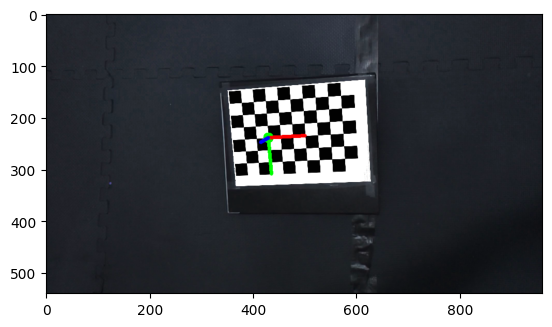

In [2]:
import matplotlib.pyplot as plt
plt.imshow(frame)

In [3]:
rvec

array([[ 0.1316682 ],
       [ 0.242503  ],
       [-0.06749414]])

## playaround

In [4]:
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=model.get_center())
coordinate_frame.compute_vertex_normals()


TriangleMesh with 1134 points and 2240 triangles.

In [5]:
model = copy.deepcopy(mesh)

In [6]:
model.get_center()
r_mat = model.get_rotation_matrix_from_xyz((np.pi/2, 0, 0))
cent = model.get_center()
model = model.rotate(r_mat, center=cent)


In [7]:

# model = model.normalize_normals()
# model = model.scale(0.5,(0,0,0))

In [8]:
model.get_center()

array([-1.17091637e-02,  1.13559741e+02, -1.37710673e+00])

In [9]:
tvec

array([[  4.62008946],
       [ -2.22928349],
       [115.19506484]])

In [10]:
# move rvec to degrees from radians
np.rad2deg(rvec)

array([[ 7.54403243],
       [13.89439837],
       [-3.86712925]])

In [11]:
# tvec.flatten() * [1, -1, -1]

In [ ]:
# # Convert rotation vector to rotation matrix
R, _ = cv2.Rodrigues(rvec)
# Adjust rotation matrix for Open3D
R_conversion = np.array([
    [1,  0,  0],
    [0, -1,  0],
    [0,  0, -1]
])
R_o3d = R @ R_conversion  # Convert OpenCV R to Open3D R

R = R_o3d#np.eye(3) @ R_conversion
# Build Open3D transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = R
transformation_matrix[:3, 3] = tvec.flatten() * 10#* [1, -1, -1]

vis = o3d.visualization.Visualizer()
vis.create_window(visible=True)
# vis.create_window(visible=True, width=intrinsic.width, height=intrinsic.height)

# Add lighting (Phong shading)
opt = vis.get_render_option()
opt.light_on = True  # Enable lighting
opt.background_color = np.array([0, 0, 0])  # White background
# vis.add_geometry(model)
vis.add_geometry(model)

# Get the view control to set the camera intrinsics
ctr = vis.get_view_control()
cam_params = o3d.camera.PinholeCameraParameters()
cam_params.intrinsic = intrinsic
cam_params.extrinsic = transformation_matrix  # Aligns object with camera


ctr.convert_from_pinhole_camera_parameters(cam_params, allow_arbitrary=True)
        
# Capture image from Open3D
# ctr.set_zoom(0.8)
# ctr.set_lookat([0, 0, 0])
# ctr.set_up([0, -1, 0])
# ctr.set_front([0, 0, -1])

print("before run")
# vis.poll_events()
# vis.update_renderer()
vis.run()
print("after run")
render = vis.capture_screen_float_buffer(do_render=True)
vis.destroy_window()

# Convert Open3D float buffer to OpenCV format
render = (np.array(render) * 255).astype(np.uint8)
print(f"rendered size: {render.shape}; image size: {(width, height)}")
# Convert from RGB to BGR
render = cv2.cvtColor(render, cv2.COLOR_RGB2BGR)


before run
after run

KeyboardInterrupt: 

: 

In [10]:
model

TriangleMesh with 1953 points and 3534 triangles, and textures of size (2048, 2048) 

In [11]:
model.get_center()

array([-1.17091637e-02,  1.13559741e+02, -1.37710673e+00])

In [12]:
tvec

array([[  4.62008946],
       [ -2.22928349],
       [115.19506484]])

In [13]:
transformation_matrix

array([[ 9.68530904e-01, -8.24478930e-02, -2.34840868e-01,
         4.62008946e+00],
       [-5.07321096e-02, -9.89127426e-01,  1.38033284e-01,
         2.22928349e+00],
       [-2.43668097e-01, -1.21775529e-01, -9.62183236e-01,
        -1.15195065e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [14]:
coordinate_frame.get_center()

array([ 3.99663213e-02,  1.13611417e+02, -1.32543124e+00])